# Wind Downscaling


In [1]:
import os
from datetime import date, datetime
from pathlib import Path
from dotenv import load_dotenv
from data.data_generator import BatchGenerator, NaiveDecoder, LocalFileProvider, S3FileProvider, NoiseGenerator
from gan import train, metrics
from gan.models import make_discriminator
load_dotenv()
import numpy as np
import tensorflow as tf
import tensorflow.keras.callbacks as cb
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
import pandas as pd

Num GPUs Available: 0


## Set configuration

In [2]:
DATA_ROOT = Path('./data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
COSMO1_DATA_FOLDER = DATA_ROOT / 'COSMO1'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'

DATA_ROOT.mkdir(parents=True, exist_ok=True)
ERA5_DATA_FOLDER.mkdir(exist_ok=True)
COSMO1_DATA_FOLDER.mkdir(exist_ok=True)
DEM_DATA_FILE.parent.mkdir(exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)
cosmoblurred = True
run_id=datetime.today().strftime('%Y%m%d_%H%M')
data_provider = 'local'

In [3]:
# Start and end date for the data - should be in the 2016-2020 range
START_DATE = date(2017,1,1)
END_DATE = date(2017,12,31)
NUM_DAYS = (END_DATE-START_DATE).days + 1
# Number of consecutive images to form a sequence
SEQUENCE_LENGTH = 3
# Size of the high resolution image to be produced
IMG_SIZE = 64
# Number of sequences per batch
BATCH_SIZE = 8

In [4]:
TOPO_PREDICTORS = ['tpi_500', 'slope', 'aspect']
HOMEMADE_PREDICTORS = ['e_plus', 'e_minus', 'w_speed', 'w_angle']
ERA5_PREDICTORS_SURFACE = ['u10', 'v10', 'blh', 'fsr', 'sp', 'sshf']
ERA5_PREDICTORS_Z500 = ['z']
if cosmoblurred:
    ALL_INPUTS = ['U_10M', 'V_10M'] + HOMEMADE_PREDICTORS + TOPO_PREDICTORS
    input_pattern = 'x_cosmo_{date}.nc'
    run_id = f'{run_id}_cosmo_blurred'
else:
    ALL_INPUTS = ERA5_PREDICTORS_Z500 + ERA5_PREDICTORS_SURFACE + TOPO_PREDICTORS + HOMEMADE_PREDICTORS
    input_pattern = 'x_{date}.nc'
ALL_INPUTS = ['U_10M', 'V_10M']
ALL_OUTPUTS = ['U_10M', 'V_10M']
BATCH_WORKERS = os.cpu_count()
if data_provider == 'local':
    input_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, input_pattern)
    output_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, 'y_{date}.nc')
elif data_provider == 's3':
    input_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern=input_pattern)
    output_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern='y_{date}.nc')
else:
    raise ValueError(f'Wrong value for data provider {data_provider}: please choose between s3 and local')
AVAIL_DATES = [pd.to_datetime(v) for v in
               set(input_provider.available_dates).intersection(output_provider.available_dates)]
START_DATE = min(AVAIL_DATES)
END_DATE = max(AVAIL_DATES)
batch_gen = BatchGenerator(input_provider, output_provider,
                                    decoder=NaiveDecoder(normalize=True),
                                    sequence_length=SEQUENCE_LENGTH,
                                    patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                                    input_variables=ALL_INPUTS,
                                    output_variables=ALL_OUTPUTS,
                                    start_date=START_DATE, end_date=END_DATE,
                                    num_workers=BATCH_WORKERS)
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)


In [5]:
inputs = []
outputs = []
with batch_gen as batch:
    for b in range(NUM_DAYS):
        print(f'Creating batch {b+1}/{NUM_DAYS}')
        x, y = next(batch)
        inputs.append(x)
        outputs.append(y)
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)

Creating batch 1/365
Creating batch 2/365
Creating batch 3/365
Creating batch 4/365
Creating batch 5/365
Creating batch 6/365
Creating batch 7/365
Creating batch 8/365
Creating batch 9/365
Creating batch 10/365
Creating batch 11/365
Creating batch 12/365
Creating batch 13/365
Creating batch 14/365
Creating batch 15/365
Creating batch 16/365
Creating batch 17/365
Creating batch 18/365
Creating batch 19/365
Creating batch 20/365
Creating batch 21/365
Creating batch 22/365
Creating batch 23/365
Creating batch 24/365
Creating batch 25/365
Creating batch 26/365
Creating batch 27/365
Creating batch 28/365
Creating batch 29/365
Creating batch 30/365
Creating batch 31/365
Creating batch 32/365
Creating batch 33/365
Creating batch 34/365
Creating batch 35/365
Creating batch 36/365
Creating batch 37/365
Creating batch 38/365
Creating batch 39/365
Creating batch 40/365
Creating batch 41/365
Creating batch 42/365
Creating batch 43/365
Creating batch 44/365
Creating batch 45/365
Creating batch 46/3

Creating batch 355/365
Creating batch 356/365
Creating batch 357/365
Creating batch 358/365
Creating batch 359/365
Creating batch 360/365
Creating batch 361/365
Creating batch 362/365
Creating batch 363/365
Creating batch 364/365
Creating batch 365/365


In [6]:
print(f"Inputs: {inputs.shape}")
print(f"Outputs: {outputs.shape}")
n_examples = inputs.shape[0]
noise = NoiseGenerator(inputs.shape)()[...,:2]
x = np.concatenate([inputs, noise], axis=0)
x = (x, np.concatenate([outputs, outputs], axis=0))
y = np.concatenate([np.ones(n_examples), -np.ones(n_examples)])
print(x[0].shape, x[1].shape, y.shape)

Inputs: (2920, 3, 64, 64, 2)
Outputs: (2920, 3, 64, 64, 2)
(5840, 3, 64, 64, 2) (5840, 3, 64, 64, 2) (5840,)


In [7]:
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [8]:
discriminator = make_discriminator(low_res_size=IMG_SIZE, high_res_size=IMG_SIZE,
                               low_res_channels=INPUT_CHANNELS,
                               high_res_channels=OUT_CHANNELS,
                                        n_timesteps=SEQUENCE_LENGTH)
print(f"Generator: {discriminator.count_params():,} weights")

def loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

discriminator.compile(optimizer=train.discriminator_optimizer(),
                  metrics=['accuracy'],
                  loss=loss)

Generator: 3,303,241 weights


In [9]:
checkpoint_path_weights = Path('./checkpoints/discriminator') / run_id / 'weights-{epoch:02d}.ckpt'
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/discriminator') / run_id
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [10]:
%load_ext tensorboard
%tensorboard --logdir=$log_path

In [11]:
callbacks = [
        cb.TensorBoard(log_path, write_images=True, update_freq='batch'),
        cb.ProgbarLogger('steps'),
        cb.TerminateOnNaN(),
        cb.ModelCheckpoint(str(checkpoint_path_weights), save_best_only=False, period=10,
                           save_weights_only=True),
    ]

In [12]:
discriminator.fit(x=x, y=y, callbacks=callbacks, epochs=50)

Epoch 1/50
183/183 [==============================] - 312s 2s/step - loss: -78.2010 - accuracy: 0.0798
Epoch 2/50
183/183 [==============================] - 255s 1s/step - loss: -874.9581 - accuracy: 0.0411
Epoch 3/50
183/183 [==============================] - 256s 1s/step - loss: -1600.8780 - accuracy: 0.0026
Epoch 4/50
183/183 [==============================] - 292s 2s/step - loss: -2236.5484 - accuracy: 0.0139
Epoch 5/50
183/183 [==============================] - 288s 2s/step - loss: -3215.0449 - accuracy: 0.0504
Epoch 6/50
183/183 [==============================] - 279s 2s/step - loss: -4404.0065 - accuracy: 0.0226
Epoch 7/50
183/183 [==============================] - 292s 2s/step - loss: -5356.0052 - accuracy: 6.7282e-04
Epoch 8/50
183/183 [==============================] - 260s 1s/step - loss: -6421.0321 - accuracy: 4.2693e-04
Epoch 9/50
183/183 [==============================] - 259s 1s/step - loss: -7539.1659 - accuracy: 5.5555e-04
Epoch 10/50
183/183 [=========================

ResourceExhaustedError: checkpoints/discriminator/20211029_1031_cosmo_blurred/weights-40.ckpt_temp/part-00000-of-00001.data-00000-of-00001.tempstate3835843332834296058; No space left on device [Op:SaveV2]

In [13]:
scores_true = discriminator([inputs, outputs])
scores_fake = discriminator([noise, outputs])

In [14]:
scores_true_np = scores_true.numpy()
scores_true_np = np.squeeze(scores_true_np)
scores_fake_np = scores_fake.numpy()
scores_fake_np = np.squeeze(scores_fake_np)

<ipython-input-35-5778f58792bc>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


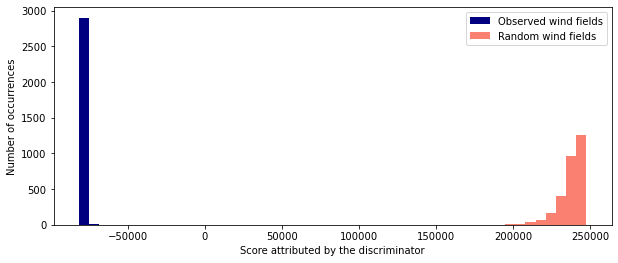

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1, figsize=(10,4))
range = [np.min(scores_true_np), np.max(scores_fake_np)]
ax.hist(scores_true_np, bins=50, color='navy', range=range, label='Observed wind fields')
ax.hist(scores_fake_np, bins=50, color='salmon', range=range, label='Random wind fields')
ax.set_xlabel('Score attributed by the discriminator')
ax.set_ylabel('Number of occurrences')
fig.show()
plt.legend()

(array([4.00269702e-08, 4.00268971e-08, 1.20080911e-07, 1.20080691e-07,
        4.00269702e-07, 1.04070122e-06, 3.60242074e-06, 1.14477135e-05,
        3.38227280e-05, 6.62446356e-05]),
 array([161763.64, 170319.52, 178875.4 , 187431.28, 195987.17, 204543.05,
        213098.92, 221654.81, 230210.69, 238766.58, 247322.45],
       dtype=float32),
 <BarContainer object of 10 artists>)

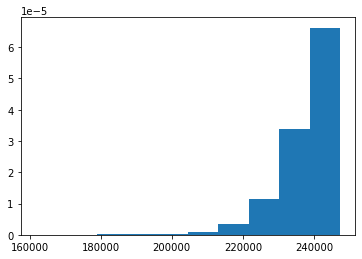